## Unsupervised Learning – Principal Component Analysis

### Practical task: Iris dataset

Bronwyn Bowles-King

### 1. Load libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings
warnings.filterwarnings("always")

### 2. Load dataset and preview

In [2]:
try:
    df = pd.read_csv('Iris.csv')
except FileNotFoundError:
    print('File not found. Check directory.')

display(df.head())

print(f"Dataframe dimensions: {df.shape}")

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


Dataframe dimensions: (150, 6)


In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             150 non-null    int64  
 1   SepalLengthCm  150 non-null    float64
 2   SepalWidthCm   150 non-null    float64
 3   PetalLengthCm  150 non-null    float64
 4   PetalWidthCm   150 non-null    float64
 5   Species        150 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 7.2+ KB
None


### 3. Drop unnecessary columns and rename dataframe

In [4]:
try:
    df_iris = df.drop('Id', axis=1)
    print("Column removed.")
except KeyError:
    print("Column previously removed.")

Column removed.


### 4. View summary statistics

In [5]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

display(df_iris.describe())

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
count,150.00,150.00,150.00,150.00
mean,5.84,3.05,3.76,1.20
std,0.83,0.43,1.76,0.76
min,4.30,2.00,1.00,0.10
25%,5.10,2.80,1.60,0.30
50%,5.80,3.00,4.35,1.30
75%,6.40,3.30,5.10,1.80
max,7.90,4.40,6.90,2.50


### 5. Check for duplicates

While there are three identical rows found below, some flowers out of the 150 measured may well be exactly the same size. These duplicate pairs are from the same species as the whole row must match, including the species column. This data seems to be valid and, therefore, I will not drop these rows. No missing data was found as all columns have 150 entries.

In [6]:
print(f'Duplicate rows: {df_iris.duplicated().sum()}\n')

duplicates = df_iris[df_iris.duplicated()]
display(duplicates)

Duplicate rows: 3



,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
34,4.90,3.10,1.50,0.10,Iris-setosa
37,4.90,3.10,1.50,0.10,Iris-setosa
142,5.80,2.70,5.10,1.90,Iris-virginica


### 6. Univariate histograms

The four histograms show the distributions of the main features: sepal length, sepal width, petal length, and petal width. Sepal length and width in Figure 1a and 1b are somewhat symmetrically or normally distributed or closer to a bell curve, but the shape is not exact. These features have skew to the left, indicating variation but also that most flowers have a sepal length and width of less than 7 cm and 3.5 cm, respectively.

Petal length and width in Figure 1c and 1d show bimodal or multimodal patterns. This suggests some divergence and that some iris species could be distinguishable based on these measurements. The separation between petal measurements means they could be useful for species classification, whereas sepal features have more overlap. 

Overall, the histograms suggest that petal size could provide stronger separation between species than other features and they may contribute to Principal Component Analysis (PCA) more.

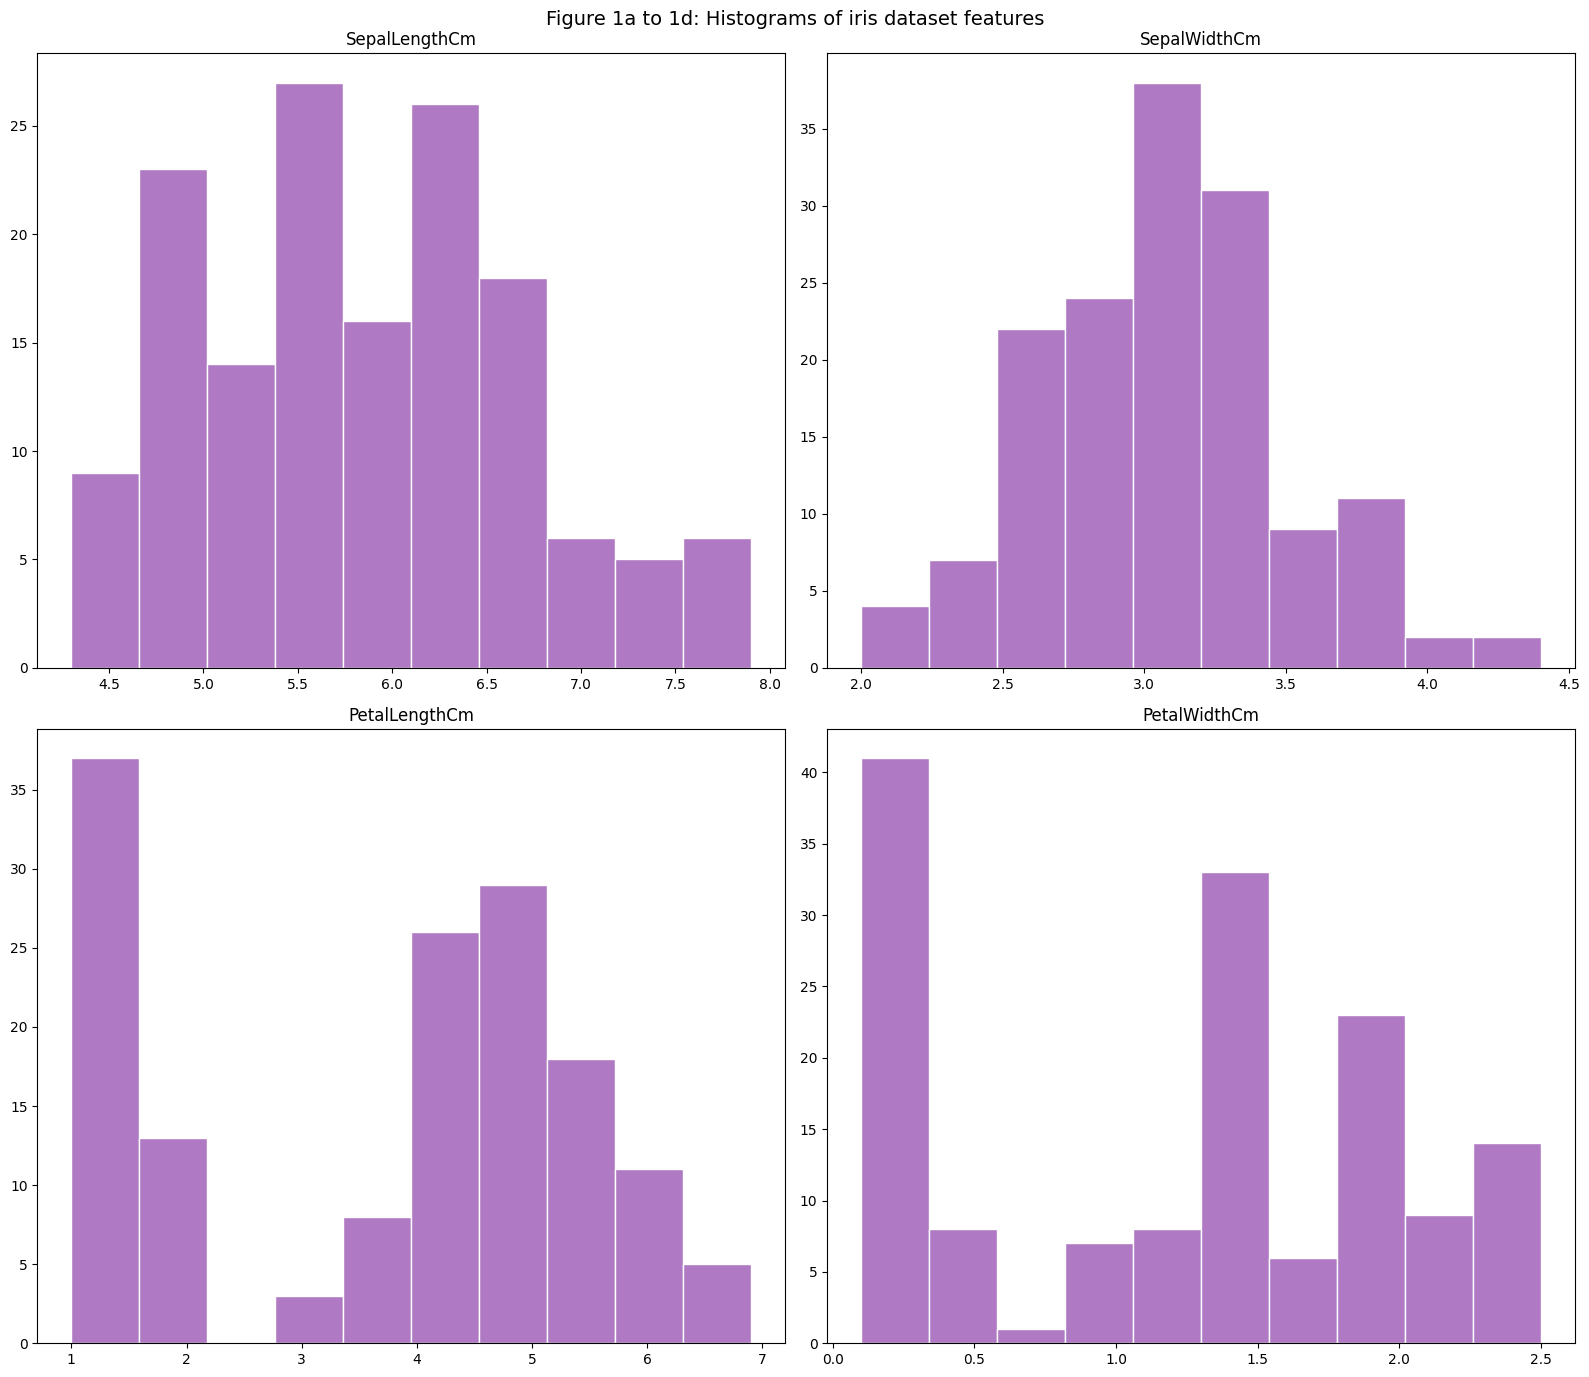

In [7]:
histograms = df_iris.hist(color='#9c59b6ce', grid=False, edgecolor='white', figsize=(16, 14))
plt.suptitle('Figure 1a to 1d: Histograms of iris dataset features', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])  
plt.tight_layout()
plt.show()

### 7. Correlation map

The correlation map in Figure 2 shows that petal width and length are the most strongly correlated features (0.96). The association is very strong and can be valuable in distingushing between species, as also suggested by the histograms above. There is also considerable correlation between sepal length and petal length (0.87) and width (0.82), respectively. 

The negative correlations between features in the correlation map show that certain pairs of measurements show great difference between them. A high value for one measurement is mainly linked to a lower value for the other feature. This is clearly the case for sepal width compared to petal length (-0.42) and width (-0.36), respectively, as well as sepal length and width, but to a lesser extent (-0.11). 

To understand this better, we can consider that the negative correlation between sepal width and petal length (-0.42) means that, across the samples we have in this dataset, flowers with wider sepals tend to have shorter petals. 

Both positive and negative correlations are valuable in species classification and can come into play in PCA.

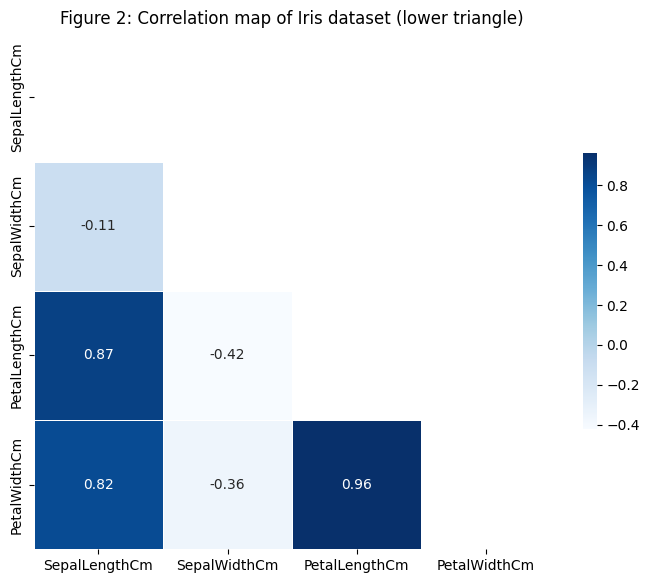

In [8]:
def plot_corr_map(dataframe, cmap='Blues', title='Correlation heatmap', show_mask=True):
    """
    Plot lower triangle correlation map.

    Parameters:
    - dataframe: pd.DataFrame with numerical features to correlate.
    - cmap: str, colour map for the heatmap.
    - title: str, plot title.
    - show_mask: bool, whether to mask the upper triangle.
    """
    corr = dataframe.corr(numeric_only=True)
    mask = np.triu(np.ones_like(corr, dtype=bool)) if show_mask else None

    plt.figure(figsize=(7, 6))
    sns.heatmap(
        corr,
        cmap=cmap,
        annot=True,
        mask=mask,
        square=True,
        linewidths=0.5,
        cbar_kws={'shrink': 0.5}
    )
    plt.title(title)
    plt.tight_layout()
    plt.show()


plot_corr_map(
    df_iris, 
    cmap='Blues', 
    title='Figure 2: Correlation map of Iris dataset (lower triangle)'
)

### 8. Standardise the data, fit and transform with PCA

The key features are now assigned to the X variable in this step, which includes all columns except species name. The sk-learn functions for standardisation and PCA are applied to fit and transform the data. The data is scaled because PCA is sensitive to the scale of each feature. Scaling ensures each feature contributes equally and measurement units do not bias the results.

PCA is run with three components as we know there are three species in the dataset. A new dataframe with PCA results is created with Principal Components (PC) 1, 2 and 3, isolating the three strongest distingushing features of the dataset. The species column is added back to compare the data with the original labels.

In [9]:
X = df_iris.drop(['Species'], axis=1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3'])
pca_df['Species'] = df['Species']

display(pca_df.head())
display(pca_df.tail())

,PC1,PC2,PC3,Species
0,-2.26,0.51,0.12,Iris-setosa
1,-2.09,-0.66,0.23,Iris-setosa
2,-2.37,-0.32,-0.05,Iris-setosa
3,-2.30,-0.58,-0.10,Iris-setosa
4,-2.39,0.67,-0.02,Iris-setosa


,PC1,PC2,PC3,Species
145,1.87,0.38,-0.25,Iris-virginica
146,1.56,-0.91,0.03,Iris-virginica
147,1.52,0.27,-0.18,Iris-virginica
148,1.38,1.02,-0.93,Iris-virginica
149,0.96,-0.02,-0.53,Iris-virginica


### 9. PCA biplot

A PCA biplot is created using code from a function from Geeks for Geeks (2025). The PCA score, coefficient matrix of feature loadings (coeff), axis labels, and classes are used. The first and second PC scores (xs and ys) are extracted for plotting on the x and y axis. 

Class labels and colours are added using a dictionary. The biplot shows arrows from the origin, representing how strongly and in what direction each original feature contributes to the first two principal components. Feature labels are placed with each arrow. 

The final biplot in Figure 3 visualises the Iris dataset according to the first two principal components. Each purple dot represents an iris flower in the samples, coloured according to species, which is specified in the legend. 

Three large clusters are apparent and they mostly correspond to the three species. The setosa species is clearly well separated to the left, but versicolor and virginica overlap more, meaning that it is harder to distinguish between them based on the available data. 

The green arrows in Figure 3 indicate the contributions of each original flower measurement (sepal length and width, petal length and width) to the new principal components. Longer arrows signify features with a stronger influence. 

The direction of each arrow shows whether a feature increases with higher principal component values. For example, petal length and petal width arrows point in a similar direction, showing these features increase together and help distinguish species. The arrangement and separation of point clusters confirm that PCA reduces dimensionality while preserving class distinctions.

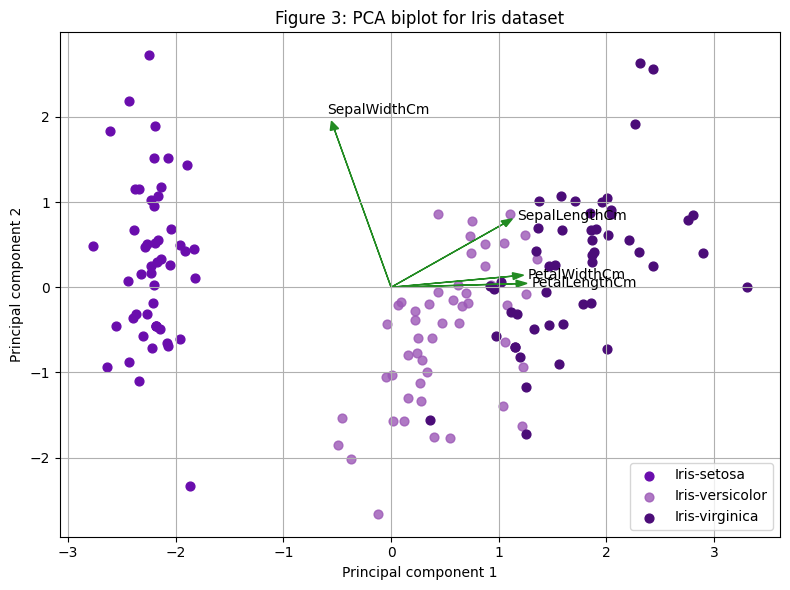

In [10]:
features = ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']
labels = features   
score = X_pca  
coeff = np.transpose(pca.components_[:2, :])   
classes = df_iris['Species'].values
xs = score[:, 0]  
ys = score[:, 1]  

plt.figure(figsize=(8, 6))  
  
species_list = np.unique(classes) if classes is not None else []  
colours = {  
    species_list[0]: '#6a0dad',  
    species_list[1]: "#9c59b6ce",  
    species_list[2]: "#4b0c78"  
}  
  
if classes is not None:  
    for species in species_list:  
        idx = classes == species  
        plt.scatter(xs[idx], ys[idx], color=colours[species], label=species, s=40)  
    plt.legend()  
else:  
    plt.scatter(xs, ys, s=40)  
  
n = coeff.shape[0]  
for i in range(n):  
    plt.arrow(0, 0, coeff[i, 0]*2, coeff[i, 1]*2,  
              color='forestgreen', head_width=0.08, head_length=0.1)  
    if labels is not None:  
        plt.text(coeff[i, 0]*2.25, coeff[i, 1]*2.25,  
                 labels[i], color='black', ha='left', va='center')  
  
plt.xlabel('Principal component 1')  
plt.ylabel('Principal component 2')  
plt.title('Figure 3: PCA biplot for Iris dataset')  
plt.grid()  
plt.tight_layout()  
plt.show()  

### 10. Hierarchical clustering dendrogram

The code chunk below performs hierarchical clustering on the standardised dataset (X_scaled) (not on the PCA-transformed results) and then plots a dendrogram of the data splitting into these clusters, starting with the smallest clusters at the bottom and moving upwards towards the largest. 

The dendrogram thus in in Figure 4 illustrates how the samples have been grouped based on similarity across measurements after standardisation. The algorthim identified three main branches which are assigned different colours. These clusters mostly but not perfectly align with the three iris species.

The complete linkage method and Euclidean distance between datapoints are then applied in agglomerative clustering as this combination best distinguishes between the three species (n_clusters=3). Cluster numbers (HierarchicalCluster) for each sample are saved to a new column in the dataframe and the first few and last few lines of the dataframe are printed at the end.

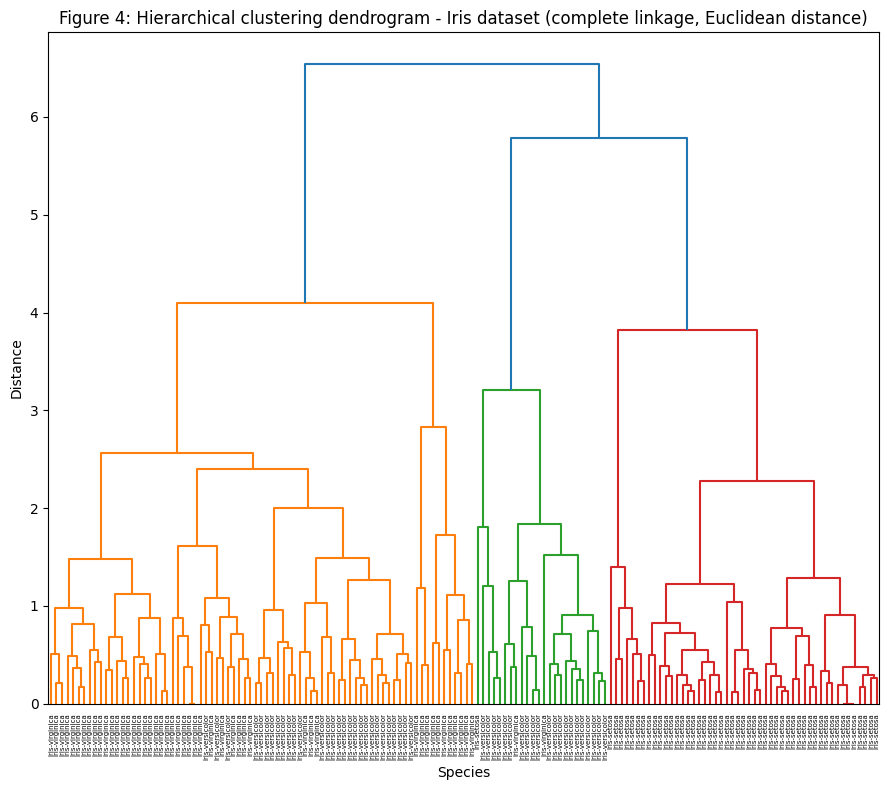

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species,HierarchicalCluster
0,5.10,3.50,1.40,0.20,Iris-setosa,1
1,4.90,3.00,1.40,0.20,Iris-setosa,1
2,4.70,3.20,1.30,0.20,Iris-setosa,1
3,4.60,3.10,1.50,0.20,Iris-setosa,1
4,5.00,3.60,1.40,0.20,Iris-setosa,1


,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species,HierarchicalCluster
145,6.70,3.00,5.20,2.30,Iris-virginica,0
146,6.30,2.50,5.00,1.90,Iris-virginica,0
147,6.50,3.00,5.20,2.00,Iris-virginica,0
148,6.20,3.40,5.40,2.30,Iris-virginica,0
149,5.90,3.00,5.10,1.80,Iris-virginica,0


In [11]:
plt.figure(figsize=(9, 8))
sch.dendrogram(
    sch.linkage(X_scaled, method='complete'),
    labels=df_iris['Species'].values
)

plt.title('Figure 4: Hierarchical clustering dendrogram - Iris dataset (complete linkage, Euclidean distance)')
plt.xlabel('Species')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

agg = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='complete')
labels_hierarchical = agg.fit_predict(X_scaled)  
df_iris['HierarchicalCluster'] = labels_hierarchical

display(df_iris.head())
display(df_iris.tail())

### 11. Build and fit K-means model

Below, clustering is performed again on the standardised dataset but using the K-means algorithm instead of agglomerative clustering and the resulting clusters are added to the dataframe at the end. 

The arguments n_clusters specifies that the algorithm should find three clusters as there are three iris species; n_init runs the K-means algorithm 10 times to increase reliability, choosing the best solution; and the random_state ensures reproducible results by setting a seed for random number generation. The fit_predict method fits the model and returns the cluster assignment (0, 1 or 2) for each sample.

The new dataframe head with the K-means results printed below shows consistency in clustering the setosa species. However, the tail shows the K-means method is inconsistent in distinguishing between virginica and versicolor. Hierarchical clustering run above was more consistent in this regard.

In [12]:
kmeans = KMeans(n_clusters=3, n_init=10, random_state=42)
labels_kmeans = kmeans.fit_predict(X_scaled)

df_iris['KMeansCluster'] = labels_kmeans

display(df_iris.head())
display(df_iris.tail())

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species,HierarchicalCluster,KMeansCluster
0,5.10,3.50,1.40,0.20,Iris-setosa,1,1
1,4.90,3.00,1.40,0.20,Iris-setosa,1,1
2,4.70,3.20,1.30,0.20,Iris-setosa,1,1
3,4.60,3.10,1.50,0.20,Iris-setosa,1,1
4,5.00,3.60,1.40,0.20,Iris-setosa,1,1


,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species,HierarchicalCluster,KMeansCluster
145,6.70,3.00,5.20,2.30,Iris-virginica,0,2
146,6.30,2.50,5.00,1.90,Iris-virginica,0,0
147,6.50,3.00,5.20,2.00,Iris-virginica,0,2
148,6.20,3.40,5.40,2.30,Iris-virginica,0,2
149,5.90,3.00,5.10,1.80,Iris-virginica,0,0


### 12. Re-create correlation map with PCA-transformed data

Instead of the original flower part measurements, the new correlation map in Figure 5 shows PCA results for three principal components. PC1 explains the largest portion of variance in the data. PC2 explains the next largest portion of the remaining variance, but it is negatively uncorrelated with PC1. 

PC1 and PC3 are the most strongly correlated features (9.5e-16) and this correlation is positive. The correlation values are also shown in a table below the figure as decimals. There are notable negative correlations between PC1 and PC2 (-5.7e16) and PC2 and PC3 (-3.4e-16). 

The numbers in Figure 5 are in scientific notation because the correlations are based on the scaled data (between -1 and 1). They are thus very small (10⁻¹⁶). This is also the case because PCA looks for data that is most strongly divergent, aiding in clearly separating groups.

The principal components are not the same as the original features and there are fewer of them than before. PCA combines the original measurements so that they capture as much variance in the original dataset as possible, simplifying classification. The principal components actually combine the real features in calculated proportions. They are weighted mixtures of the original flower measurements.

PC1, PC2, and PC3 can also be understood as the directions in the transformed feature space that successively explain the most variance. They are mathematically uncorrelated so that PCA trims away redundant data. This simplifies modelling for large, complex datasets (IBM, 2023; Jolliffe & Cadima 2016).

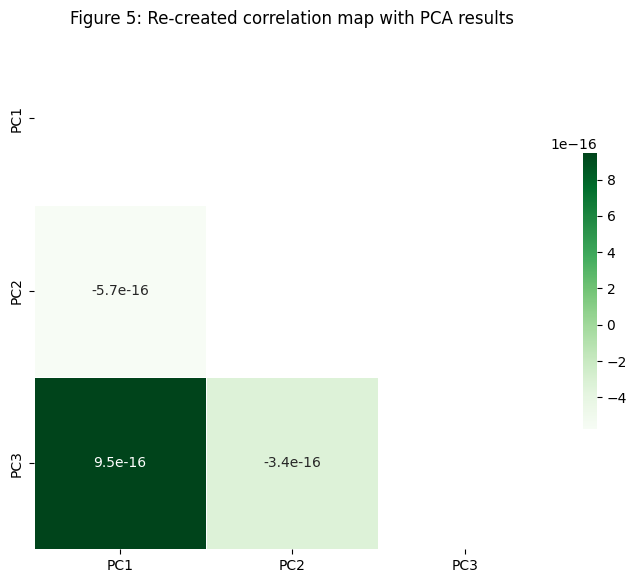

,PC1,PC2,PC3
PC1,1.00000000000000000,-0.00000000000000057,0.00000000000000095
PC2,-0.00000000000000057,1.00000000000000000,-0.00000000000000034
PC3,0.00000000000000095,-0.00000000000000034,1.00000000000000000


In [13]:
plot_corr_map(
    pca_df,
    cmap='Greens',
    title='Figure 5: Re-created correlation map with PCA results'
)

pca_corr = pca_df.corr(numeric_only=True)

pd.set_option('display.float_format', lambda x: '%.17f' % x)

display(pca_corr)

#### References

Geeks for Geeks. (2025). Feature Importance in PCA: Analyzing Loadings and Biplots. https://www.geeksforgeeks.org/machine-learning/feature-importance-in-pca-analyzing-loadings-and-biplots

HyperionDev. (2025). Unsupervised Learning – Principal Component Analysis. Course materials. Private repository, GitHub.

IBM. (2023). What is principal component analysis (PCA)? https://www.ibm.com/think/topics/principal-component-analysis

Jolliffe, I. T., & Cadima, J. (2016). Principal component analysis: a review and recent developments. *Philosophical Transactions Series A, Mathematical, physical, and engineering sciences*, 374(2065), 20150202. https://doi.org/10.1098/rsta.2015.0202

Omusi, B. (n.d.). The Iris dataset. RPubs. https://rpubs.com/analystben/chapter-2

scikit-learn. (2025). AgglomerativeClustering. https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html

scikit-learn. (2025). KMeans. https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

scikit-learn. (2025). Principal Component Analysis (PCA) on Iris Dataset. https://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_iris.html

SciPy. (2008). Hierarchical clustering. https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html